Loads the QuickDraw dataset. Demonstrates reading the original files, working with the data as a sequence of strokes, and converting those strokes to images. Also writes a dataset to disk in a convenient format.

In [0]:
from __future__ import print_function

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import functools, itertools, json, os, re, textwrap
import tensorflow as tf

from PIL import Image, ImageDraw
from six.moves.urllib import request
from xml.dom import minidom

# Get the data

In [4]:
# Retrieve list of classes.

def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCE bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
print('available: (%d)' % len(all_ndjsons))
print('\n'.join(textwrap.wrap(
    ' '.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons]),
    width=100)))

available: (309)
The Eiffel Tower The Great Wall of China The Mona Lisa aircraft carrier airplane alarm clock
ambulance angel animal migration ant anvil apple arm asparagus axe backpack banana bandage barn
baseball bat baseball basket basketball bat bathtub beach bear beard bed bee belt bench bicycle
binoculars bird birthday cake blackberry blueberry book boomerang bottlecap bowtie bracelet brain
bread bridge broccoli broom bucket bulldozer bus bush butterfly cactus cake calculator calendar
camel camera camouflage campfire candle cannon canoe car carrot castle cat ceiling fan cell phone
cello chair chandelier church circle clarinet clock cloud coffee cup compass computer cookie cooler
couch cow crab crayon crocodile crown cruise ship cup diamond dishwasher diving board dog dolphin
donut door dragon dresser drill drums duck dumbbell ear elbow elephant envelope eraser eye
eyeglasses face fan feather fence finger fire hydrant fireplace firetruck fish flamingo flashlight
flip flops floor l

In [0]:
# Store all data locally in this directory.
data_path = 'data'
if not os.path.exists(data_path): 
  os.mkdir(data_path)

# Mini group of two animals.
pets = ['cat', 'dog']

# Somewhat larger group of zoo animals.
zoo = ['elephant', 'giraffe', 'kangaroo', 'lion', 'monkey', 'panda',
       'penguin', 'rhinoceros', 'tiger', 'zebra']

# Even larger group of all animals.
animals = ['bat', 'bird', 'butterfly', 'camel', 'cat', 'cow', 'crab',
           'crocodile', 'dog', 'dolphin', 'duck', 'elephant', 'fish',
           'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl',
           'panda', 'parrot', 'penguin', 'pig', 'rabbit', 'raccoon',
           'rhinoceros', 'scorpion', 'sea turtle', 'shark', 'sheep',
           'snail', 'spider', 'squirrel', 'teddy-bear', 'tiger',
           'whale', 'zebra']

# Create your own group -- the more classes you include the more challenging
# the classification task will be...

# Choose one of the above groups.
# Note: This will result in ~100MB of download per class.
classes, classes_name = animals, 'animals'

In [6]:
# Download the chosen group.

def valid_ndjson(filename):
    """Checks presence + completeness of .ndjson file."""
    try:
        json.loads(open(filename).readlines()[-1])
        return True
    except (ValueError, IOError):
        return False

def retrieve(bucket, key, filename):
    """Returns a file specified by its Key from a GCE bucket."""
    url = 'https://storage.googleapis.com/%s/%s' % (bucket, key)
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
    while not valid_ndjson(filename):
        print('*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20))
        request.urlretrieve(url=url, filename=filename)

if not os.path.exists(data_path):
    os.mkdir(data_path)

print('\n%d classes:' % len(classes))

for name in classes:
    print(name, end=' ')
    dst = '%s/%s.ndjson' % (data_path, name)
    retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
    print('%.2f MB' % (os.path.getsize(dst) / 2.**20))

print('\nDONE :)')



43 classes:
bat 58.02 MB
bird 65.86 MB
butterfly 63.27 MB
camel 54.31 MB
cat 73.12 MB
cow 91.94 MB
crab 76.46 MB
crocodile 57.19 MB
dog 87.06 MB
dolphin 46.29 MB
duck 67.93 MB
elephant 70.86 MB
fish 48.59 MB
frog 92.50 MB
giraffe 58.27 MB
hedgehog 90.76 MB
horse 99.79 MB
kangaroo 96.06 MB
lion 90.47 MB
lobster 86.65 MB
monkey 91.05 MB
mosquito 64.99 MB
mouse 76.35 MB
octopus 79.30 MB
owl 108.10 MB
panda 97.04 MB
parrot 96.42 MB
penguin 137.90 MB
pig 124.13 MB
rabbit 95.05 MB
raccoon 89.36 MB
rhinoceros 92.20 MB
scorpion 104.07 MB
sea turtle 70.49 MB
shark 48.55 MB
sheep 80.55 MB
snail 69.58 MB
spider 115.32 MB
squirrel 100.65 MB
teddy-bear 128.27 MB
tiger 86.09 MB
whale 53.94 MB
zebra 92.10 MB

DONE :)


# Inspect the data

In [7]:
# So let's check out the downloaded files...
!ls -lh $data_path

total 3.5G
-rw-r--r-- 1 root root  59M Nov  5 21:51  bat.ndjson
-rw-r--r-- 1 root root  66M Nov  5 21:51  bird.ndjson
-rw-r--r-- 1 root root  64M Nov  5 21:51  butterfly.ndjson
-rw-r--r-- 1 root root  55M Nov  5 21:51  camel.ndjson
-rw-r--r-- 1 root root  74M Nov  5 21:51  cat.ndjson
-rw-r--r-- 1 root root  92M Nov  5 21:51  cow.ndjson
-rw-r--r-- 1 root root  77M Nov  5 21:51  crab.ndjson
-rw-r--r-- 1 root root  58M Nov  5 21:51  crocodile.ndjson
-rw-r--r-- 1 root root  88M Nov  5 21:51  dog.ndjson
-rw-r--r-- 1 root root  47M Nov  5 21:51  dolphin.ndjson
-rw-r--r-- 1 root root  68M Nov  5 21:51  duck.ndjson
-rw-r--r-- 1 root root  71M Nov  5 21:52  elephant.ndjson
-rw-r--r-- 1 root root  49M Nov  5 21:52  fish.ndjson
-rw-r--r-- 1 root root  93M Nov  5 21:52  frog.ndjson
-rw-r--r-- 1 root root  59M Nov  5 21:52  giraffe.ndjson
-rw-r--r-- 1 root root  91M Nov  5 21:52  hedgehog.ndjson
-rw-r--r-- 1 root root 100M Nov  5 21:52  horse.ndjson
-rw-r--r-- 1 root root  97M Nov  5 21:52  kangaro

In [8]:
# What is the NDJSON file format?
# Seems to be one JSON dictionary per line...
path = sorted(tf.gfile.Glob(os.path.join(data_path, '*.ndjson')))[1]
print(open(path).read()[:1000] + '...')

{"word":"bird","countrycode":"US","timestamp":"2017-03-09 00:28:55.63775 UTC","recognized":true,"key_id":"4926006882205696","drawing":[[[0,11,23,50,72,96,97,132,158,224,255],[22,9,2,0,26,45,71,40,27,10,9]]]}
{"word":"bird","countrycode":"US","timestamp":"2017-03-29 04:22:58.82297 UTC","recognized":true,"key_id":"5357674197680128","drawing":[[[65,194,221,240,250,255,251,242,227,210,173,154,133,86,58,55],[102,104,111,120,130,151,161,173,181,184,186,181,170,138,106,94]],[[211,216],[133,138]],[[208,205,205],[154,164,159]],[[94,82,74,74,83,91,106,139,164],[143,165,196,244,250,250,242,211,146]],[[107,108,111,127,155,175,181,181,176,178],[84,53,44,20,2,0,16,52,79,92]],[[42,25,3,0],[94,89,62,39]]]}
{"word":"bird","countrycode":"US","timestamp":"2017-03-17 19:31:28.87981 UTC","recognized":true,"key_id":"5553672849195008","drawing":[[[159,163,175,189,201,209,227,245,253,255],[15,9,2,0,5,16,8,7,15,23]],[[124,108,101,97,96,105,152,159,171,178,179,168,154,140,125],[52,50,55,63,81,93,115,114,101,73,

In [9]:
# Parse single line.
data_json = json.loads(open(path).readline())
data_json.keys()

[u'word', u'countrycode', u'timestamp', u'recognized', u'key_id', u'drawing']

In [10]:
# So we have some meta information...
for k, v in data_json.items():
    if k != 'drawing':
        print('%20s   ->   %s' % (k, v))

                word   ->   bird
         countrycode   ->   US
           timestamp   ->   2017-03-09 00:28:55.63775 UTC
          recognized   ->   True
              key_id   ->   4926006882205696


In [11]:
# ...and the actual drawing.
drawing = data_json['drawing']
# The drawing consists of a series of strokes:
[np.array(stroke).shape for stroke in drawing]

[(2, 11)]

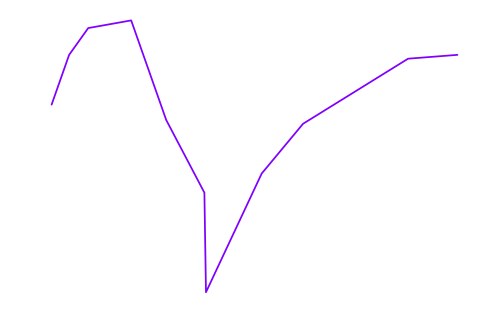

In [12]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:

def draw_strokes(drawing):
  # Use a different color for each stroke
  colors = cm.rainbow(np.linspace(0, 1, len(drawing)))
  plt.axis('off')
  for stroke, c in zip(drawing, colors):
    #print(stroke[0], stroke[1])
    plt.plot(np.array(stroke[0]), -1 * np.array(stroke[1]), color=c)
    
draw_strokes(drawing)

In [13]:
# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single line to JSON + converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
    """Returns iterable of drawings in specified file.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    for line in open('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)
        if d['recognized'] or unrecognized:
            yield d

def loadn(name, n, unrecognized=False):
    """Returns list of drawings.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      n: Number of drawings to load.
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    it = loaditer(name, unrecognized=unrecognized)
    return list(itertools.islice(it, 0, n))

print('loading some "%s"...' % classes[0])
sample = loadn(classes[0], 100)

loading some "bat"...


In [14]:
sample[0]

{u'countrycode': u'RO',
 u'drawing': [array([[111,  89,  79,  77,  82,  89, 103, 113, 126, 125, 104],
         [ 53, 106, 147, 174, 179, 180, 172, 156, 114,  54,  55]]),
  array([[103, 103, 111, 126, 137, 137, 127],
         [ 53,  17,   1,   2,  14,  25,  44]]),
  array([[113,  98,  45,  41,  40,  45,  27,  22,  21,  25,  20,   2,   0,
            8,  42,  61,  73],
         [ 55,  48,  12,  10,  13,  53,  54,  61,  93, 125, 126, 115, 123,
          136, 165, 167, 158]]),
  array([[132, 143, 158, 171, 208, 215, 219, 248, 251, 255, 254, 242, 227,
          233, 233, 222, 211, 187, 144, 125, 111, 107],
         [ 61,  56,  37,  26,  12,  65,  67,  65,  67,  82, 102, 130, 153,
          156, 160, 173, 180, 188, 189, 189, 186, 181]])],
 u'key_id': u'5073402912047104',
 u'recognized': True,
 u'timestamp': u'2017-03-07 14:44:14.70063 UTC',
 u'word': u'bat'}

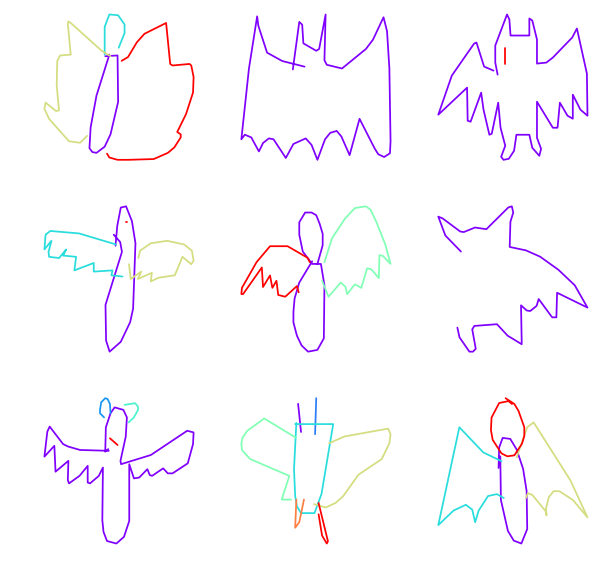

In [15]:
# Some more drawings...
plt.figure(figsize=(10, 10))
n = 3
for x in range(n):
    for y in range(n):
        i = x * n + y
        plt.subplot(n, n, i + 1)
        drawing = sample[i]['drawing']
        draw_strokes(drawing)
        
# Elephants!

In [16]:
# Let's first check how many [recognized=True] examples we have in each class.
# Depending on your choice of classes you could generate >200k examples / class...
for name in classes:
    print(name, len(list(open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name))))

bat 118114 recognized 96152
bird 133572 recognized 111611
butterfly 117999 recognized 114549
camel 121399 recognized 115454
cat 123202 recognized 103031
cow 123083 recognized 101099
crab 126930 recognized 106466
crocodile 127932 recognized 106410
dog 152159 recognized 143285
dolphin 121613 recognized 110335
duck 135480 recognized 113764
elephant 126969 recognized 104986
fish 134150 recognized 126420
frog 159047 recognized 145286
giraffe 127182 recognized 122396
hedgehog 120527 recognized 103226
horse 178286 recognized 156302
kangaroo 174470 recognized 152511
lion 120949 recognized 98976
lobster 140175 recognized 118228
monkey 127633 recognized 105650
mosquito 123029 recognized 116609
mouse 178826 recognized 166197
octopus 150152 recognized 143558
owl 169632 recognized 147654
panda 113613 recognized 94814
parrot 185530 recognized 163567
penguin 253791 recognized 231826
pig 186770 recognized 164788
rabbit 155288 recognized 133323
raccoon 119588 recognized 101174
rhinoceros 188484 recogni

# Strokes -> Pictures

In [0]:
# The sequence information is important! But... for now we'll 
# convert these sequences to plain old images.

In [0]:
def json_to_img(drawing, img_sz=64, lw=3, maximize=True):
    img = Image.new('L', (img_sz, img_sz))
    draw = ImageDraw.Draw(img)
    lines = np.array([
        stroke[0:2, i:i+2]
        for stroke in drawing
        for i in range(stroke.shape[1] - 1)
    ], dtype=np.float32)
    if maximize:
        for i in range(2):
            min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
            lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
    else:
        lines /= 1024
    for line in lines:
        draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
    return img

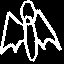

In [19]:
json_to_img(drawing)

zebra


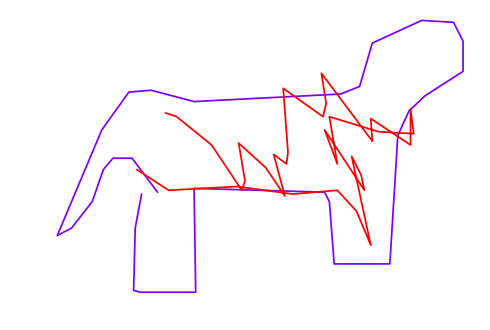

In [20]:
# Fetch some images + shuffle order.
n_per_class = 10000
drawings_matrix = [loadn(name, n_per_class) for name in classes]
drawings_list = functools.reduce(lambda x, y: x + y, drawings_matrix, [])
np.random.seed(1)
drawings_list = np.random.permutation(drawings_list)

# Quick test to see how our code works so far
draw_strokes(drawings_list[0]['drawing'])
print(str(drawings_list[0]['word']))

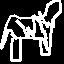

In [21]:
json_to_img(drawings_list[0]['drawing'])

# Save a dataset to disk

In [0]:
X, y = [], []
for drawing in drawings_list:
  X.append(np.array(json_to_img(drawing['drawing'])))
  y.append(str(drawing['word']))
  
dataset_path = 'mini-quickdraw.npz'
out = open(dataset_path, 'w')
np.savez_compressed(out, X, y, X=X, y=y)

# After Saving - Start from here

In [33]:
# Demonstrate loading
dataset_path = 'mini-quickdraw.npz'
loaded = np.load(open(dataset_path))
X, y = loaded["X"], loaded["y"]
print(X.shape, y.shape)

(430000, 64, 64) (430000,)


zebra


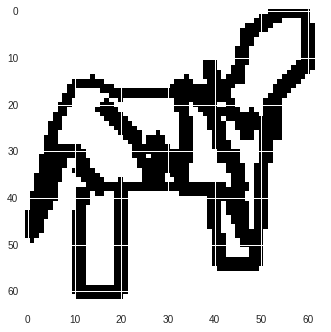

In [34]:
plt.imshow(X[0])
print(y[0])

## Importing utilities from scikit

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

## Reshaping and rescaling the data

In [0]:
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
X = X/255

## Encoding the labels to integers and then converting them to arrays

In [0]:
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
y = tf.keras.utils.to_categorical(y)

### Splitting data into train and test using a stratified split so each class is represented

In [0]:
sss = StratifiedShuffleSplit(train_size=344000, n_splits=1, 
                             test_size=86000, random_state=0)  

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Sequential Model with 4 Convolutional Layers and 2 Dense Layers

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(64,64,1), padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(43, activation='softmax')
])

In [0]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [41]:
model_history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2)

Train on 275200 samples, validate on 68800 samples
Epoch 1/30
275200/275200 [==============================] - 130s 472us/step - loss: 1.4320 - acc: 0.5894 - val_loss: 0.9117 - val_acc: 0.7289
Epoch 2/30
275200/275200 [==============================] - 130s 474us/step - loss: 0.9849 - acc: 0.7056 - val_loss: 0.7942 - val_acc: 0.7602
Epoch 3/30
275200/275200 [==============================] - 131s 476us/step - loss: 0.8841 - acc: 0.7335 - val_loss: 0.7607 - val_acc: 0.7689
Epoch 4/30
275200/275200 [==============================] - 127s 463us/step - loss: 0.8267 - acc: 0.7486 - val_loss: 0.7418 - val_acc: 0.7731
Epoch 5/30
275200/275200 [==============================] - 129s 470us/step - loss: 0.7864 - acc: 0.7595 - val_loss: 0.7130 - val_acc: 0.7817
Epoch 6/30
275200/275200 [==============================] - 145s 525us/step - loss: 0.7557 - acc: 0.7678 - val_loss: 0.7035 - val_acc: 0.7860
Epoch 7/30
275200/275200 [==============================] - 177s 642us/step - loss: 0.7332 - acc:

## Evaluating on the test dataset

In [42]:
loss, accuracy = model.evaluate(X_test, y_test)

86000/86000 [==============================] - 15s 172us/step


In [43]:
print('Test Loss: {0:.4f}'.format(loss))
print('Test Accuracy: {0:.3f}'.format(accuracy))

Test Loss: 0.6868
Test Accuracy: 0.793


In [0]:
def plot_history(histories, key='loss'):
    
    """
    Not sure if this works when epoch=1 but works when epoch is higher than 1
    """
    plt.figure(figsize=(20,10))
    for name, model_history in histories:
      train = plt.plot([x+1 for x in model_history.epoch], model_history.history[key],
                         label='Train '+ name)
      plt.plot([x+1 for x in model_history.epoch], model_history.history['val_'+ key], '--', color=train[0].get_color(),
                   label='Val ' + name)

    plt.xlabel('Epochs', fontsize=12)
    plt.xticks([x+1 for x in model_history.epoch])
    plt.ylabel(key.replace('_',' '), fontsize=12)
    plt.legend(loc=1, prop={'size': 12})
    plt.title('Plot of {} at different Epochs'.format(key), fontsize=18)

## Plotting the model metrics at different epochs

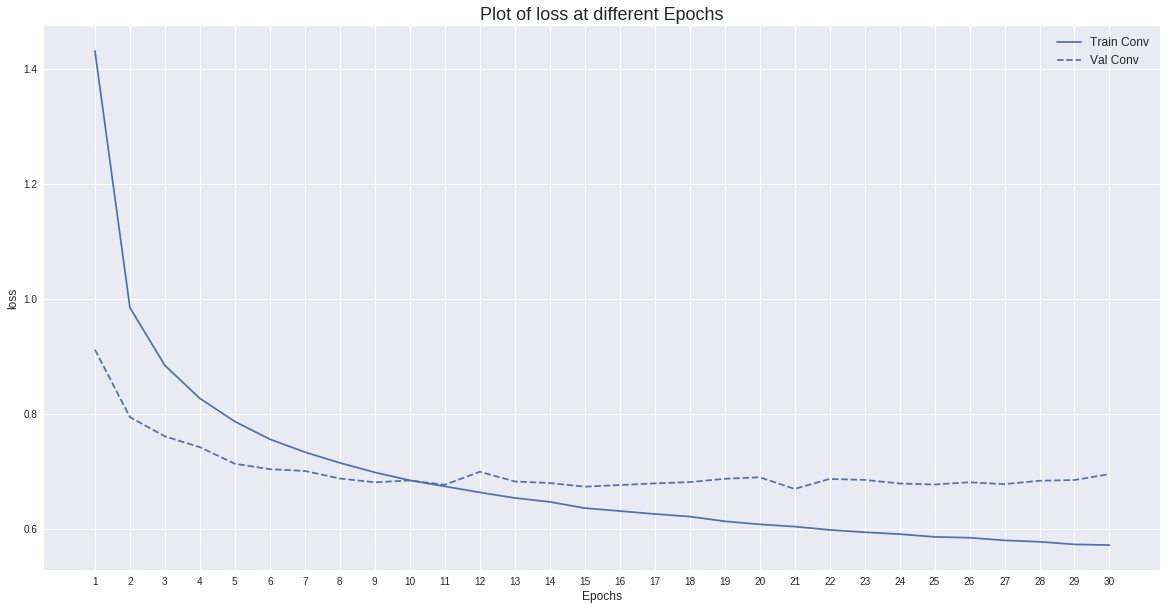

In [45]:
plot_history([('Conv', model_history)],  key='loss')

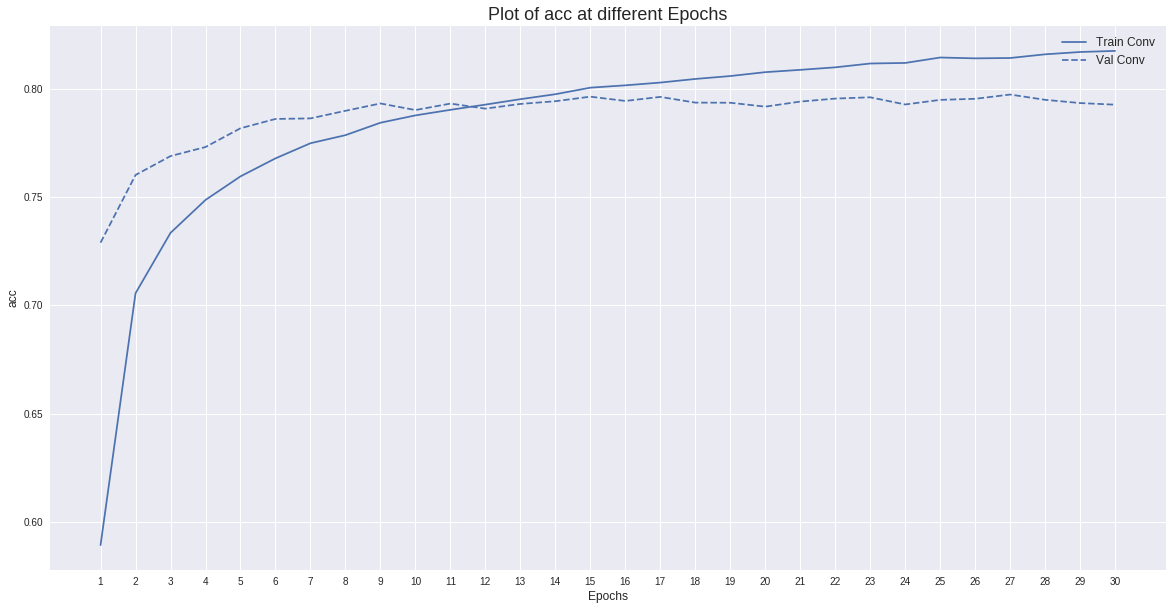

In [46]:
plot_history([('Conv', model_history)],  key='acc')

## Function to find the best model epoch based on validation loss

In [0]:
def find_best_model_epoch(histories, key='val_sparse_categorical_crossentropy', better='lower'):
    low_key_val = 1000.0
    high_key_val = 0.0
    for model, model_history in histories:
        key_val = np.array(model_history.history[key])
        if better == 'lower':
            best_val = np.min(key_val)
            if best_val < low_key_val:
                low_key_val = best_val
                best_model = model
                best_model_name = model.name
                best_epoch = np.argmin(key_val) + 1

        elif better == 'higher':
            best_val = np.max(key_val)
            if best_val > high_key_val:
                high_key_val = best_val
                best_model = model
                best_model_name = model.name
                best_epoch = np.argmax(key_val) + 1
        
    return best_model, best_model_name, best_epoch

In [0]:
best_model, best_model_name, best_epoch = find_best_model_epoch([(model, model_history)], key='val_loss')

## Retraining the model to the best epoch based on validation loss

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(64,64,1), padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(43, activation='softmax')
])

In [0]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [52]:
model_history = model.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/21
344000/344000 [==============================] - 189s 550us/step - loss: 1.3501 - acc: 0.6096
Epoch 2/21
344000/344000 [==============================] - 188s 547us/step - loss: 0.9714 - acc: 0.7080
Epoch 3/21
344000/344000 [==============================] - 188s 547us/step - loss: 0.8894 - acc: 0.7321
Epoch 4/21
344000/344000 [==============================] - 188s 547us/step - loss: 0.8454 - acc: 0.7436
Epoch 5/21
344000/344000 [==============================] - 188s 546us/step - loss: 0.8188 - acc: 0.7511
Epoch 6/21
344000/344000 [==============================] - 188s 546us/step - loss: 0.8004 - acc: 0.7551
Epoch 7/21
344000/344000 [==============================] - 188s 546us/step - loss: 0.7862 - acc: 0.7597
Epoch 8/21
344000/344000 [==============================] - 188s 545us/step - loss: 0.7742 - acc: 0.7631
Epoch 9/21
344000/344000 [==============================] - 188s 546us/step - loss: 0.7681 - acc: 0.7644
Epoch 10/21
344000/344000 [============================

## Evaluation on test data

In [53]:
loss, accuracy = model.evaluate(X_test, y_test)

86000/86000 [==============================] - 15s 176us/step


In [54]:
print('Test Loss: {0:.4f}'.format(loss))
print('Test Accuracy: {0:.3f}'.format(accuracy))

Test Loss: 0.6913
Test Accuracy: 0.787


## Summary

* The dataset chosen for this model has all 43 classes from the animal dataset and hence is more challenging to classify
* About 10000 images per class were used across the training, validation and test datasets
* Sequential Model with 4 Convolutional Layers and 2 Dense Layers was used. Maxpool layers and a dropout layer was also part of the network
* The model had the lowest validation loss at 21 epochs while the test loss continued to decrease. The model was retrained to 21 epochs to avoid overfitting
<br><br>
* Performance on the test dataset:
    * Test Loss of **0.691**
    * Test Accuracy of **78.7%**